Sample FIFA team ratings:
               team_name  season  starter_mean   sub_mean  \
0  1. FC Heidenheim 1846    2015     73.363636  69.285714   
1  1. FC Heidenheim 1846    2022     73.363636  69.285714   
2  1. FC Heidenheim 1846    2023     73.363636  69.285714   
3  1. FC Heidenheim 1846    2024     73.181818  70.714286   
4             1. FC Köln    2014     73.636364  70.285714   

   team_rating_weighted  num_players  
0             72.140260         23.0  
1             72.140260         23.0  
2             72.140260         23.0  
3             72.441558         27.0  
4             72.631169         26.0  

Sample real-world performance metrics:
    season      league  league_id  team_id          team_name  played  wins  \
60    2021  Bundesliga         78      157      Bayern Munich      34    24   
61    2021  Bundesliga         78      165  Borussia Dortmund      34    22   
62    2021  Bundesliga         78      168   Bayer Leverkusen      34    19   
63    2021  Bunde

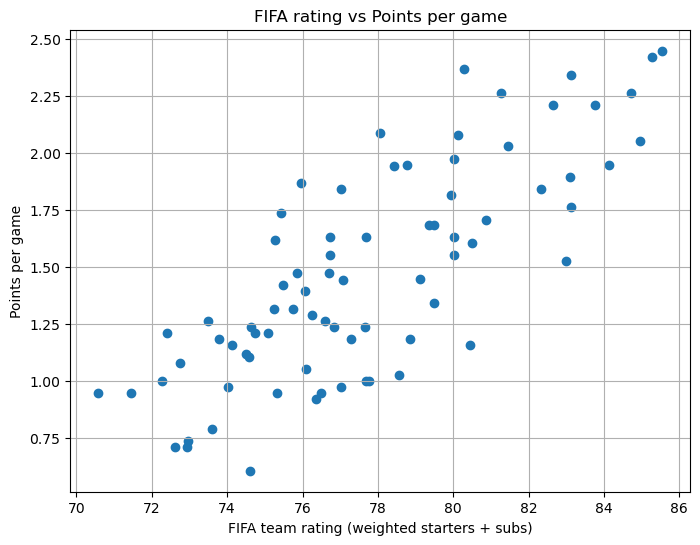

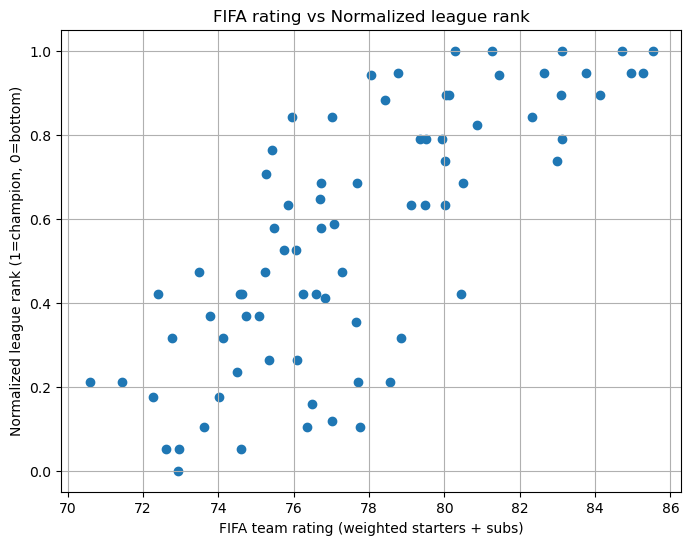

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 1. LOAD DATA
# =========================

# If df_top5 is already in memory, skip this and comment it out.
# Otherwise, load from a CSV you exported earlier.
df_top5 = pd.read_csv("top5_leagues_standings.csv")

sofifa = pd.read_csv("sofifa.csv")
sofifa["Overall rating"] = pd.to_numeric(sofifa["Overall rating"], errors="coerce")


# =========================
# 2. CLEAN SOFIFA: TEAM NAME & EDITION → SEASON
# =========================

def extract_team(team_contract):
    """Get team name from 'Team & Contract' (before the newline)."""
    if isinstance(team_contract, str):
        return team_contract.split("\n")[0].strip()
    return None

sofifa["team_name"] = sofifa["Team & Contract"].apply(extract_team)


def extract_fifa_number(edition):
    """'FIFA 15' -> 15 as int."""
    if isinstance(edition, str):
        parts = edition.split()
        try:
            return int(parts[-1])
        except ValueError:
            return None
    return None

sofifa["fifa_number"] = sofifa["Edition"].apply(extract_fifa_number)

def fifa_to_season_year(fifa_number):
    """
    Map FIFA edition to an approximate season year.
    Example: FIFA 15 -> 2014, FIFA 16 -> 2015, etc.
    Adjust this if your project defines it differently.
    """
    if pd.isna(fifa_number):
        return None
    return 2000 + fifa_number - 1  # e.g., 15 -> 2014

sofifa["season"] = sofifa["fifa_number"].apply(fifa_to_season_year)


# =========================
# 3. COMPUTE TEAM-LEVEL FIFA RATINGS (STARTERS VS SUBS)
# =========================

def compute_team_ratings(group, n_starters=11, n_subs=7,
                         starter_weight=0.7, sub_weight=0.3):
    """
    Given a group of players for one (team, season),
    compute starter mean, sub mean, and weighted team rating.
    """
    g = group.dropna(subset=["Overall rating"]).copy()
    if g.empty:
        return pd.Series({
            "starter_mean": np.nan,
            "sub_mean": np.nan,
            "team_rating_weighted": np.nan,
            "num_players": 0
        })

    g = g.sort_values("Overall rating", ascending=False)

    starters = g.head(n_starters)
    subs = g.iloc[n_starters:n_starters + n_subs]

    starter_mean = starters["Overall rating"].mean()
    sub_mean = subs["Overall rating"].mean() if len(subs) > 0 else np.nan

    # If no subs, just use starters
    if np.isnan(sub_mean):
        team_rating_weighted = starter_mean
    else:
        team_rating_weighted = starter_weight * starter_mean + sub_weight * sub_mean

    return pd.Series({
        "starter_mean": starter_mean,
        "sub_mean": sub_mean,
        "team_rating_weighted": team_rating_weighted,
        "num_players": len(g)
    })

team_fifa = (
    sofifa
    .groupby(["team_name", "season"], as_index=False)
    .apply(compute_team_ratings)
)

# groupby + apply with as_index=False adds an extra index, clean it:
team_fifa.reset_index(drop=True, inplace=True)

print("Sample FIFA team ratings:")
print(team_fifa.head())


# =========================
# 4. BUILD REAL-WORLD PERFORMANCE METRICS FROM df_top5
# =========================

df_perf = df_top5.copy()

# Basic performance metrics
df_perf["points_per_game"] = df_perf["points"] / df_perf["played"]
df_perf["win_rate"] = df_perf["wins"] / df_perf["played"]
df_perf["draw_rate"] = df_perf["draws"] / df_perf["played"]
df_perf["loss_rate"] = df_perf["losses"] / df_perf["played"]

# League position (rank) within (league, season) based on points then goal_diff
df_perf = df_perf.sort_values(
    ["league", "season", "points", "goal_diff"],
    ascending=[True, True, False, False]
)

df_perf["rank"] = df_perf.groupby(["league", "season"]).cumcount() + 1
df_perf["teams_in_league"] = df_perf.groupby(["league", "season"])["team_name"].transform("count")

# Normalized rank: 1.0 = champion, 0.0 = bottom
df_perf["normalized_rank"] = 1 - (df_perf["rank"] - 1) / (df_perf["teams_in_league"] - 1)


print("\nSample real-world performance metrics:")
print(df_perf.head())


# =========================
# 5. MERGE: FIFA TEAM RATINGS WITH REAL PERFORMANCE
# =========================

# Merge on (team_name, season). You may need to tweak team name cleaning for better matches.
merged = pd.merge(
    df_perf,
    team_fifa,
    on=["team_name", "season"],
    how="inner"
)

print("\nMerged data shape:", merged.shape)
print(merged[[
    "season", "league", "team_name",
    "points_per_game", "win_rate", "normalized_rank",
    "starter_mean", "sub_mean", "team_rating_weighted"
]].head())


# =========================
# 6. CORRELATION ANALYSIS
# =========================

performance_cols = [
    "points_per_game",
    "win_rate",
    "draw_rate",
    "loss_rate",
    "normalized_rank",
    "points",
    "goal_diff"
]

rating_cols = [
    "starter_mean",
    "sub_mean",
    "team_rating_weighted"
]

corr_matrix = merged[performance_cols + rating_cols].corr()

print("\nCorrelation matrix (ratings vs performance):")
print(corr_matrix.loc[rating_cols, performance_cols])


# =========================
# 7. SIMPLE SCATTER PLOTS (OPTIONAL)
# =========================

# Example: team_rating_weighted vs points_per_game
plt.figure(figsize=(8, 6))
plt.scatter(merged["team_rating_weighted"], merged["points_per_game"])
plt.xlabel("FIFA team rating (weighted starters + subs)")
plt.ylabel("Points per game")
plt.title("FIFA rating vs Points per game")
plt.grid(True)
plt.show()

# Example: team_rating_weighted vs normalized_rank
plt.figure(figsize=(8, 6))
plt.scatter(merged["team_rating_weighted"], merged["normalized_rank"])
plt.xlabel("FIFA team rating (weighted starters + subs)")
plt.ylabel("Normalized league rank (1=champion, 0=bottom)")
plt.title("FIFA rating vs Normalized league rank")
plt.grid(True)
plt.show()
